# Lecture 18 - Uncertainty Propagation: Polynomial Chaos II

## Objectives

+ Solve stochastic dynamical systems using intrusive polynomial chaos.
+ Solve stochastic dynamical systems using the stochastic collocation approach.

## Readings

+ These notes.

In [1]:
import numpy as np
import math
import scipy.stats as st
import scipy
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
mpl.rcParams['figure.dpi'] = 300
import seaborn as sns
sns.set_style('white')
sns.set_context('talk')
import design
import warnings
warnings.filterwarnings('ignore')
import orthpol  # This is the package we will use to construct orthogonal polynomials

## Intrusive Uncertainty Propagation Methods: Dynamical Systems

Let $X$ be a random vector with probability density $p(x)$.
Let $\phi_1,\phi_2,\dots$ be an orthonormal basis with respect to $p(x)$.
Consider the stochastic dynamical system:
Consider the $m$-dimensional dynamical system:
$$
\frac{dy}{dt} = g(y;X),
$$
with initial conditions
$$
y(0) = y_0(X).
$$

Assume that the solution $y(t;x)$ is square integrable.
Then, at a given timestep $t$, we take the solution and we expand it in the polynomial basis:
$$
y(t;x) = \sum_{i=1}^\infty c_i(t)\phi_i(x).
$$
Note that the coefficients are functions of time.
According to our discussion above, if you find these $c_i(t)$'s, the expected value of the dynamical system will be:
$$
\mathbb{E}[y(t;X)] = c_1(t),
$$
and the variance will be:
$$
\mathbb{V}[y(t;X)] = \sum_{i=2}^\infty c_i^2(t).
$$

### Derivation of the Dynamical System for the Polynomial Coefficients
We will derive a dynamical system that the coefficients must satisfy.
At the initial conditions we have:
$$
y(0;x) = y_0(x)\Rightarrow \sum_{i=1}^\infty c_i(0)\phi_i(x) = y_0(x),
$$
so we get that:
$$
c_i(0) = \langle \phi_i, y_0\rangle.
$$

Now, take the derivative of $y(t;x)$ with respect to $t$:
$$
\frac{dy}{dt} = \sum_{i=1}^\infty \frac{dc_i}{dt}\phi_i(x).
$$
This looks good, but notice that $\frac{dy}{dt} = g(y;x)$ is also a function of $y(t; x)$.
We must think of $g(y;x)$ as a function of $x$ with a fixed $y$.
Then we get:
$$
\frac{dc_i}{dt} = \left\langle \phi_i, g\left(\sum_{j=1}^\infty c_j\phi_j, \cdot\right)\right\rangle.
$$

Thus, the dynamical systme that we need to solve to find the coefficents at any time is the following:
$$
\frac{dc_i}{dt} = \left\langle \phi_i, g\left(\sum_{j=1}^\infty c_j\phi_j, \cdot\right)\right\rangle,
$$
with initial conditions:
$$
c_i(0) = \langle \phi_i, y_0\rangle,
$$
for $i=1,2,\dots$ (in practice, we truncate at a given order).


### Example 1: Dynamical System with Uncertain Parameters
Take the random vector:
$$
X = (X_1, X_2),
$$
and assume that the components are independent Gaussian:
$$
X_i \sim \mathcal{N}(\mu_i, \sigma_i^2).
$$
So, for the full random vector we have a mean:
$$
\mu = (\mu_1, \mu_2),
$$
and a covariance matrix:
$$
\Sigma = \operatorname{diag}(\sigma_1^2,\sigma_2^2).
$$

Consider the ODE:
  \begin{align*}
    &\dot{y} = \frac{d y(t)}{dt} =-X_1y(t) \equiv g(y,X),\\
    &\qquad y(0) = X_2 \equiv y_0(X).
  \end{align*}

Let's see if we can carry out the inner produces that are required for setting up the dynamical system for the polynomial coefficients:
$$
c_i(0) = \langle \phi_i, y_0\rangle = \langle \phi_i, x_2\rangle.
$$

We should be able to do this numerically with some simple quadrature rule $\{(w_q,x_q)\}_{q=1}^{N_q}$:
$$
c_{i0} = \langle \phi_i, y_0\rangle \approx \sum_{q=1}^{N_q}w_q \phi_i(x_q)x_{q,2}.
$$

The other integrals that we need are:
$$
\langle \phi_i, g\rangle = \langle \phi_i, -x_1 \sum_{j=1}^\infty c_j \phi_j\rangle = -\sum_{j=1}^\infty c_j \langle \phi_i, x_1\phi_j\rangle.
$$
We can approximate all the integrals inside the summation by:
$$
A_{ij} = \langle \phi_i, x_1\phi_j\rangle \approx \sum_{q=1}^{N_q}w_q\phi_i(x_q)x_{q1}\phi_j(x_q). 
$$

With these definitions, the dynamical system that we need to solve is:
$$
\frac{dc_i}{dt} = -\sum_{j=1}^\infty c_j A_{ij},
$$
with initial conditions:
$$
c_i(0) = c_{i0},
$$
for $i=1,2,\dots$ (we will truncate).

Let's do it.

In [2]:
# SOLUTION WITH ORTHOGONAL POLYNOMIALS

# Construct the random variables - It is not very stable to work with the original 
# random varibales (too little uncertainty).
# So, we work with scaled versions.
mu1 = 0.05; sigma1 = 0.01
sX1 = st.norm()
mu2 = 8; sigma2 = 0.01
sX2 = st.norm()
sX = (sX1, sX2)
dim = len(sX)
mu = np.array([mu1, mu2])
Sigma = np.diag([sigma1 ** 2, sigma2 ** 2])

In [3]:
# Construct the orthonormal polynomials
degree = 2
Phi_set = orthpol.ProductBasis((sX1, sX2), degree=degree, ncap=1000)
# Get a quadrature rule - we will talk about the quadrature rules in Lecture 17.
Z, v = design.sparse_grid(2, 5, 'GH') # Gauss-Hermite which uses w(x) = e^{-x^T x} - need to scale:
sXq = Z * np.sqrt(2.)
w = v / np.sqrt(np.pi ** dim)
Xq = np.ndarray(sXq.shape)
Xq[:, 0] = sXq[:, 0] * sigma1 + mu1
Xq[:, 1] = sXq[:, 1] * sigma2 + mu2

In [4]:
# Evaluate the integrals needed for defining the dynamical system
# Evaluate the orthogonal polynomials on the quadrature points
phi_q = Phi_set(sXq)
c0 = np.einsum('q,q,qj->j', w, Xq[:, 1], phi_q)
# Evaluate the integrals giving rise to the matrix A
A = np.einsum('q,q,qi,qj->ij', w, Xq[:, 0], phi_q, phi_q)

# Define the dynamical system
pc_rhs = lambda c, t: -np.dot(A, c)

# Solve the system
t = np.linspace(0, 100, 500)
c = scipy.integrate.odeint(pc_rhs, c0, t)

# Extract the mean
y_pc_m = c[:, 0]

# Extract the variance
y_pc_v = np.sum(c[:, 1:] ** 2, axis=1)

In [5]:
# SOLUTION WITH SAMPLING (FOR COMPARISON)
import scipy.integrate

class Ex1Solver(object):
    """
    An object that can solver the afforementioned ODE problem.
    It will work just like a multivariate function.
    """
    
    def __init__(self, nt=100, T=5):
        """
        This is the initializer of the class.
        
        Arguments:
            nt - The number of timesteps.
            T  - The final time.
        """
        self.nt = nt
        self.T = T
        self.t = np.linspace(0, T, nt) # The timesteps on which we will get the solution
        # The following are not essential, but they are convenient
        self.num_input = 2             # The number of inputs the class accepts
        self.num_output = nt           # The number of outputs the class returns
    
    def __call__(self, x):
        """
        This special class method emulates a function call.
        
        Arguments:
            x - A 1D numpy array with 2 elements. This represents the stochastic input x = (x1, x2).
        """
        # The dynamics of the adjoint z = y, dy/dx1, dy/dx2
        def g(z, t, x):
            return -x[0] * z[0], -x[0] * z[1] - z[0], -x[0] * z[2]
        # The initial condition
        y0 = (x[1], 0, 1)
        # We are ready to solve the ODE
        y = scipy.integrate.odeint(g, y0, self.t, args=(x,))
        return y
    
import design
num_lhs = 1000
X_lhs = design.latin_center(num_lhs, 2) # These are uniformly distributed - Turn them to standard normal
X_samples = mu + np.dot(st.norm.ppf(X_lhs), np.sqrt(Sigma))
solver = Ex1Solver(nt=500, T=100)
s = 0.
s2 = 0.
for x in X_samples:
    y = solver(x)[:, 0]
    s += y
    s2 += y ** 2
y_mu_lhs = s / num_lhs
y_var_lhs = s2 / num_lhs - y_mu_lhs ** 2

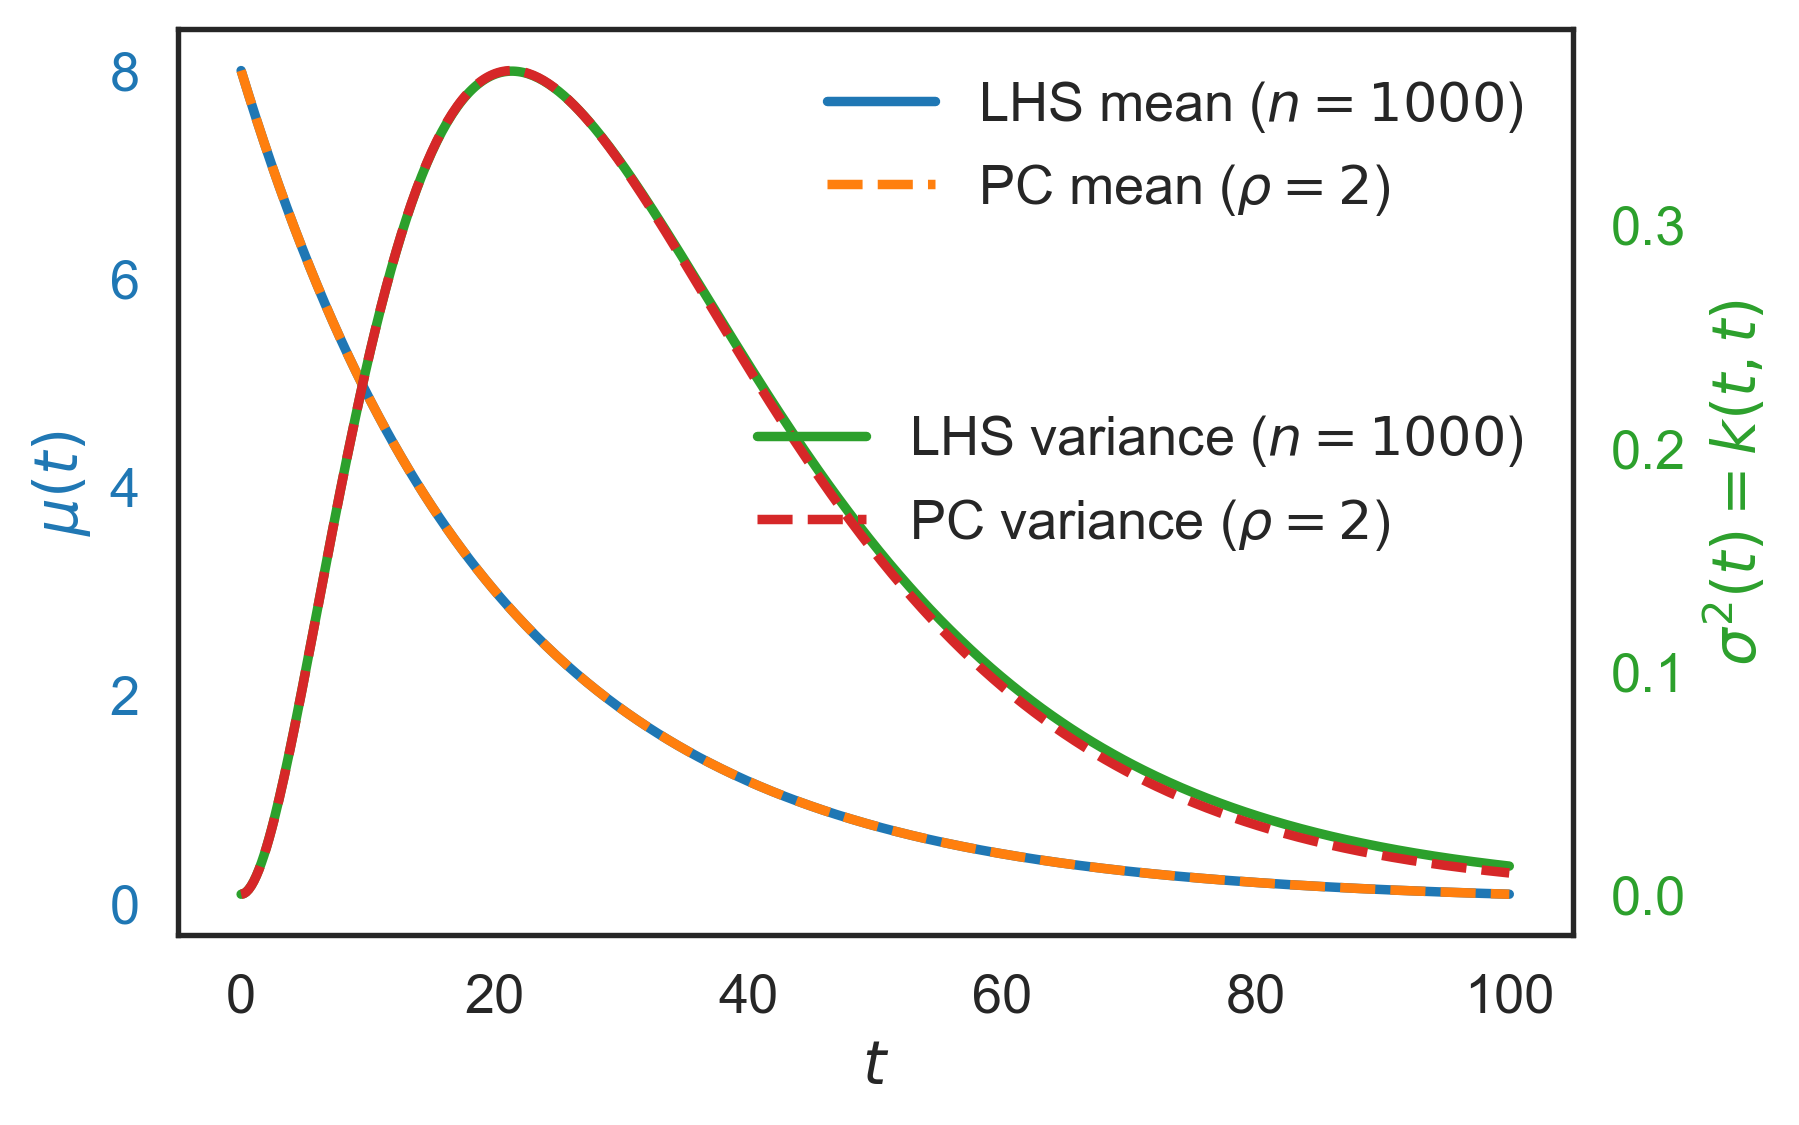

In [6]:
# Make the figure
fig1, ax1 = plt.subplots()

# Plot the mean and compare to LHS
ax1.plot(solver.t, y_mu_lhs, color=sns.color_palette()[0], label='LHS mean ($n=%d$)' % num_lhs)
ax1.plot(t, y_pc_m, '--', color=sns.color_palette()[1], label=r'PC mean ($\rho=%d$)' % degree)
ax1.set_xlabel('$t$')
ax1.set_ylabel('$\mu(t)$', color=sns.color_palette()[0])
ax1.tick_params('y', colors=sns.color_palette()[0])
plt.legend(loc='upper right')

# Plot variance and compare to LHS
ax2 = ax1.twinx()
ax2.plot(solver.t, y_var_lhs, color=sns.color_palette()[2], label='LHS variance ($n=%d$)' % (num_lhs))
ax2.plot(solver.t, y_pc_v, '--', color=sns.color_palette()[3], label=r'PC variance ($\rho=%d$)' % degree)
ax2.set_ylabel('$\sigma^2(t) = k(t, t)$', color=sns.color_palette()[2])
ax2.tick_params('y', colors=sns.color_palette()[2])
plt.legend(loc='center right');

Text(0,0.5,u'$y(t)$')

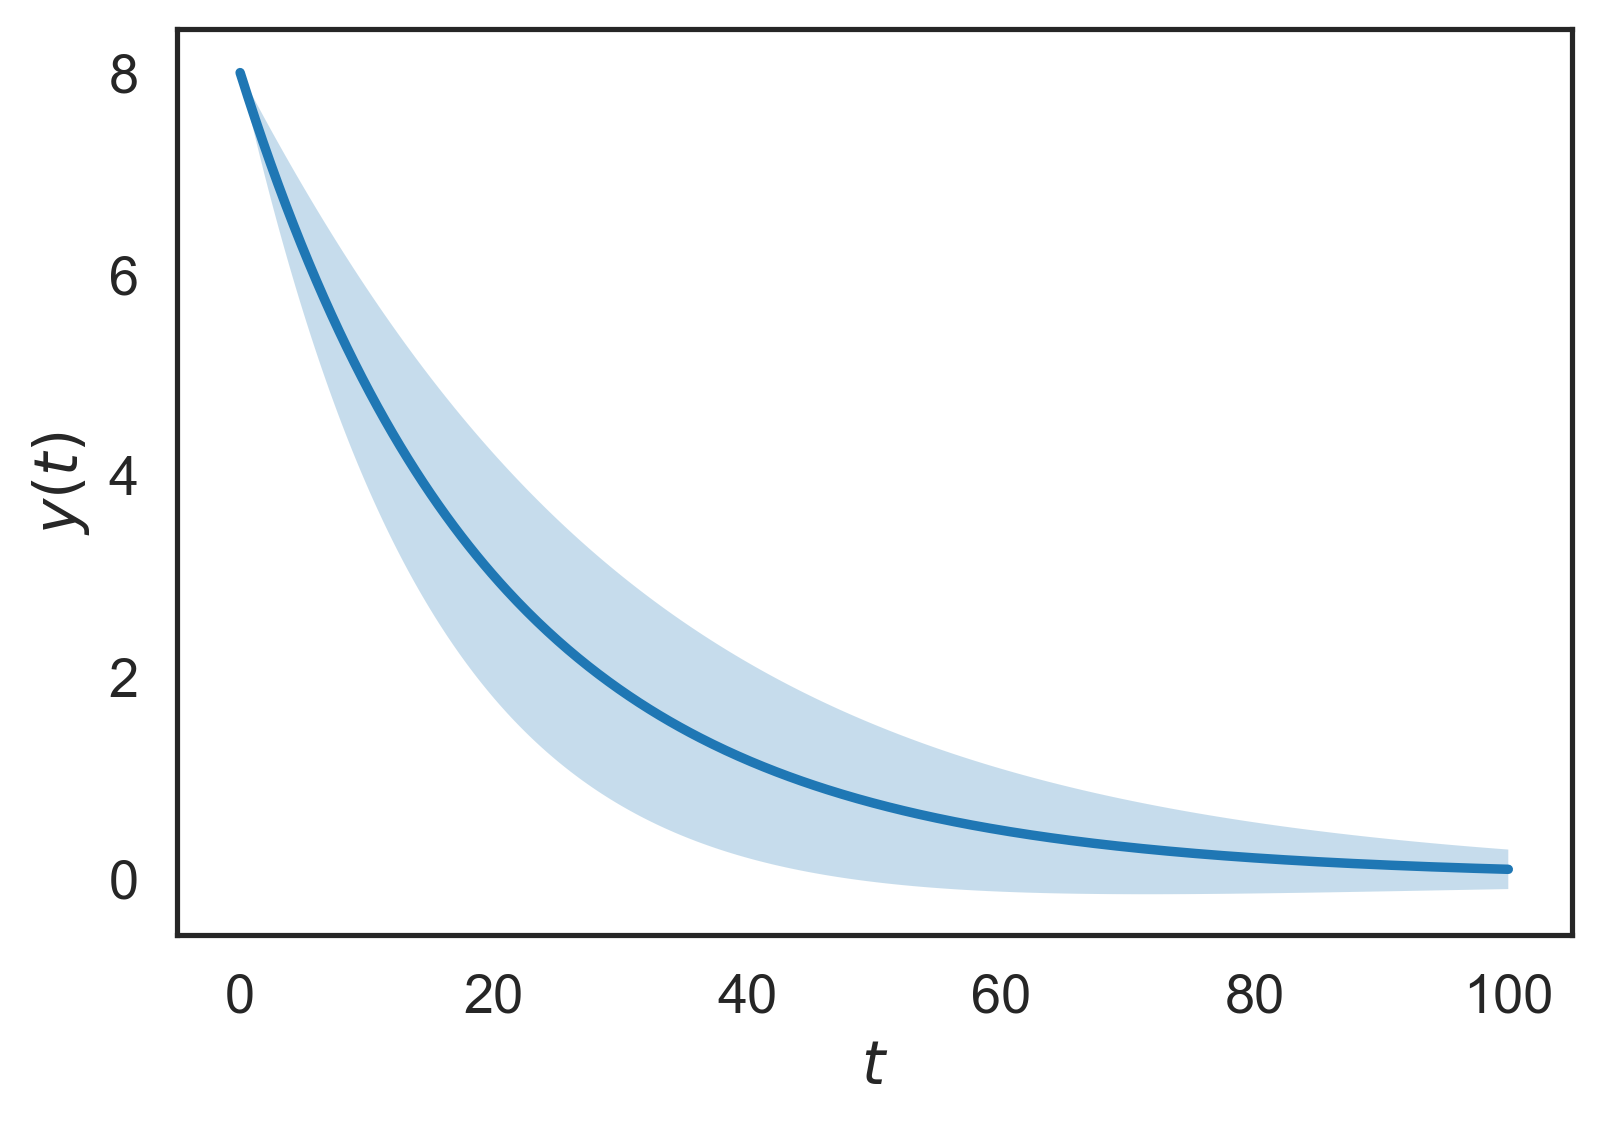

In [7]:
# Let's do 95% intervals
s = np.sqrt(y_pc_v)
l = y_pc_m - 2 * s
u = y_pc_m + 2 * s
fig, ax = plt.subplots()
ax.plot(t, y_pc_m)
ax.fill_between(t, l, u, alpha=0.25)
ax.set_xlabel('$t$')
ax.set_ylabel('$y(t)$')

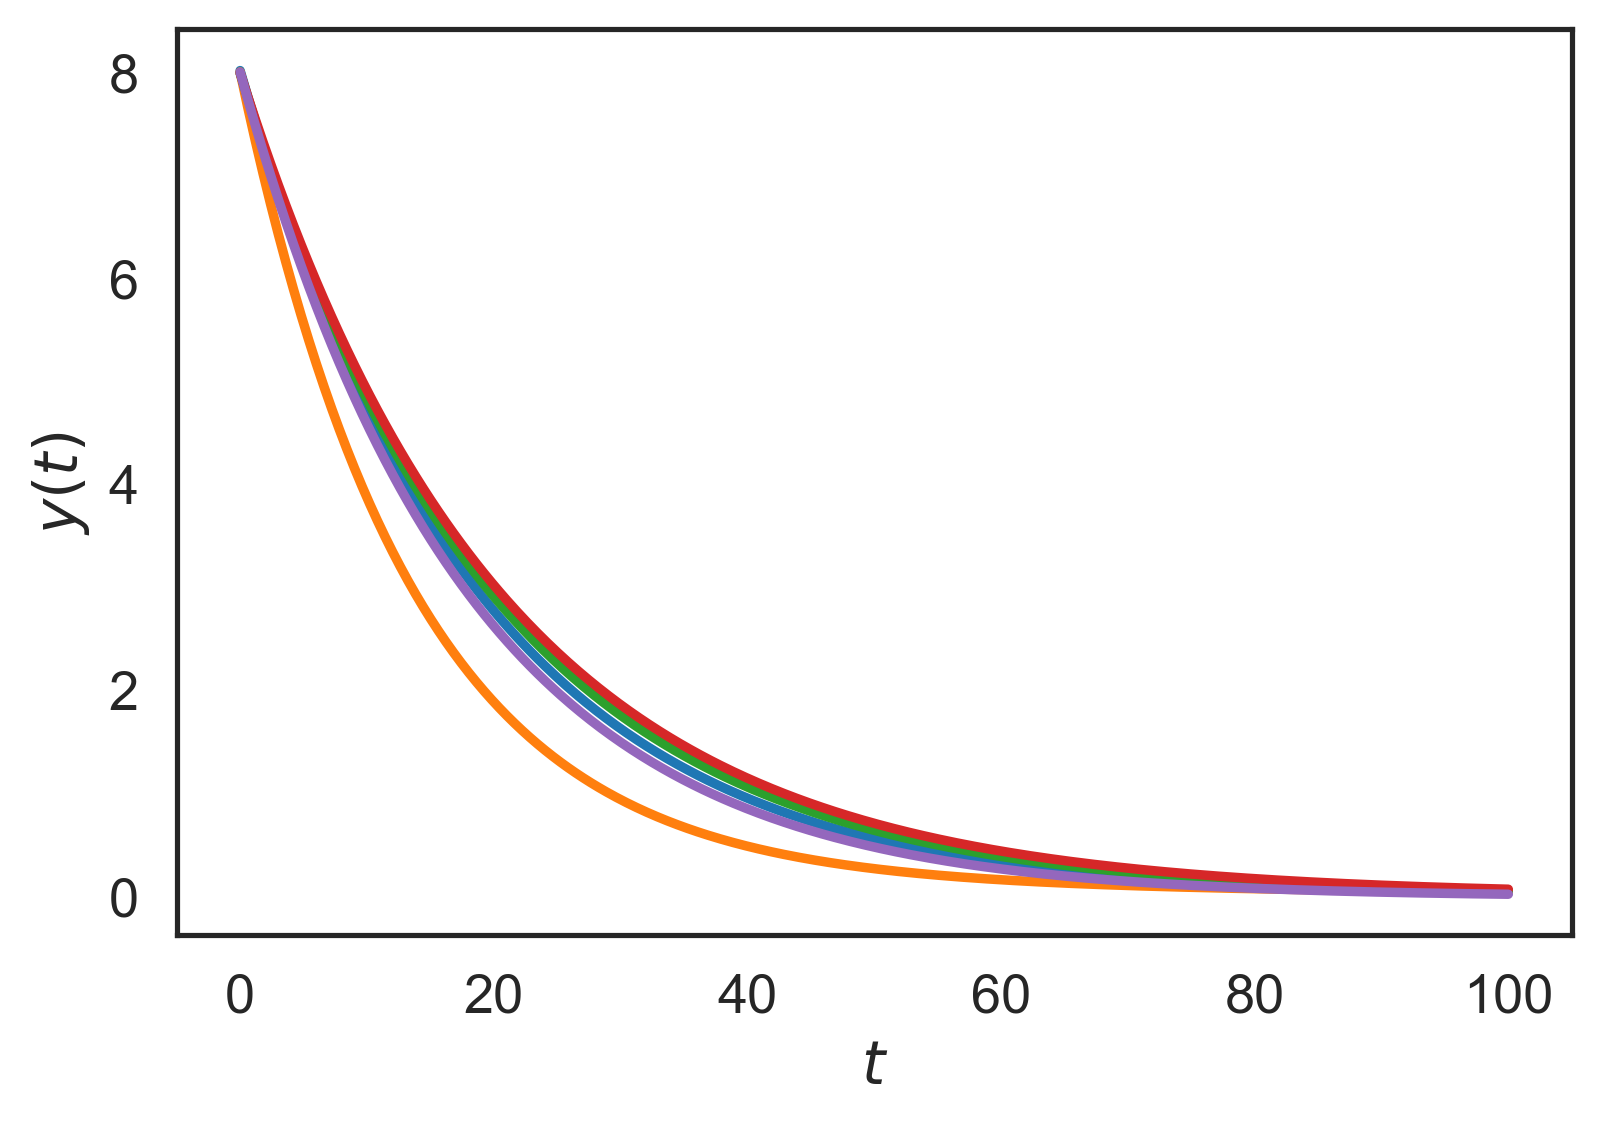

In [8]:
# Let's take some sample paths
fig, ax = plt.subplots()
ax.set_xlabel('$t$')
ax.set_ylabel('$y(t)$')
for _ in range(5):
    s_x_s = np.random.randn(2)
    y_s = np.dot(c, Phi_set(s_x_s[None, :]).T)
    ax.plot(t, y_s)

#### Questions
+ Repeat the analysis with higher polynomial degrees. What $\rho$ do you need to get convergent results?

### Example 2: Dynamical System with Uncertain Parameters

Consider the stochastic harmonic oscillator:
$$
\begin{array}{ccc}
\ddot{y} + \omega^2(X)y &=& 0,\\
y(0) &=& y_0(X),\\
\dot{y}(0) &=& v_0(X),
\end{array}
$$
where $X$ is a random variable with PDF $p(x)$.

First, let's bring this to the form of a first order dynamical system.
We set:
$$
y_1 = y,
$$
and 
$$
y_2 = \dot{y}.
$$

The dynamical system becomes:
$$
\begin{array}{ccc}
\dot{y}_1 &=& y_2,\\
\dot{y}_2 &=& -\omega^2(X) y_1,\\
y_1(0) &=& y_0(X),\\
y_2(0) &=& v_0(X).
\end{array}
$$

Let's establish some ground truth first. We will use LHS sampling to obtain estimates of the mean and variance of the displacement and velocity.

In [9]:
class Ex2Solver(object):
    """
    An object that can solver the afforementioned ODE problem.
    It will work just like a multivariate function.
    """
    
    def __init__(self, nt=100, T=5):
        """
        This is the initializer of the class.
        
        Arguments:
            nt - The number of timesteps.
            T  - The final time.
        """
        self.nt = nt
        self.T = T
        self.t = np.linspace(0, T, nt) # The timesteps on which we will get the solution
        # The following are not essential, but they are convenient
        self.num_input = 2             # The number of inputs the class accepts
        self.num_output = nt           # The number of outputs the class returns
    
    def __call__(self, x):
        """
        This special class method emulates a function call.
        
        Arguments:
            x - A 1D numpy array with 3 elements. This represents the stochastic input x = (x1, x2, x3).
        """
        x1 = x[0]
        x2 = x[1]
        x3 = x[2]
        omega = 2*np.pi + x1
        y10 = 1 +  0.1*x2
        y20 = 0.1*x3
        y0 = np.array([y10, y20])
        
        def rhs(y, t):
            A = np.array([[0, 1], [-omega**2, 0]])
            return np.dot(A, y)

        #Solve
        y = scipy.integrate.odeint(rhs, y0, self.t)
        return y[:, 0], y[:, 1]


import design
num_lhs = 1000
solver = Ex2Solver(nt=500, T=5)
X_lhs = design.latin_center(num_lhs, 3) # These are uniformly distributed - Turn them to standard normal
X_samples = scipy.stats.norm.ppf(X_lhs)
Y_samples = np.zeros((num_lhs, solver.num_output))
V_samples = np.zeros((num_lhs, solver.num_output))

In [10]:
for i in xrange(num_lhs):
    Y_samples[i], V_samples[i] = solver(X_samples[i])

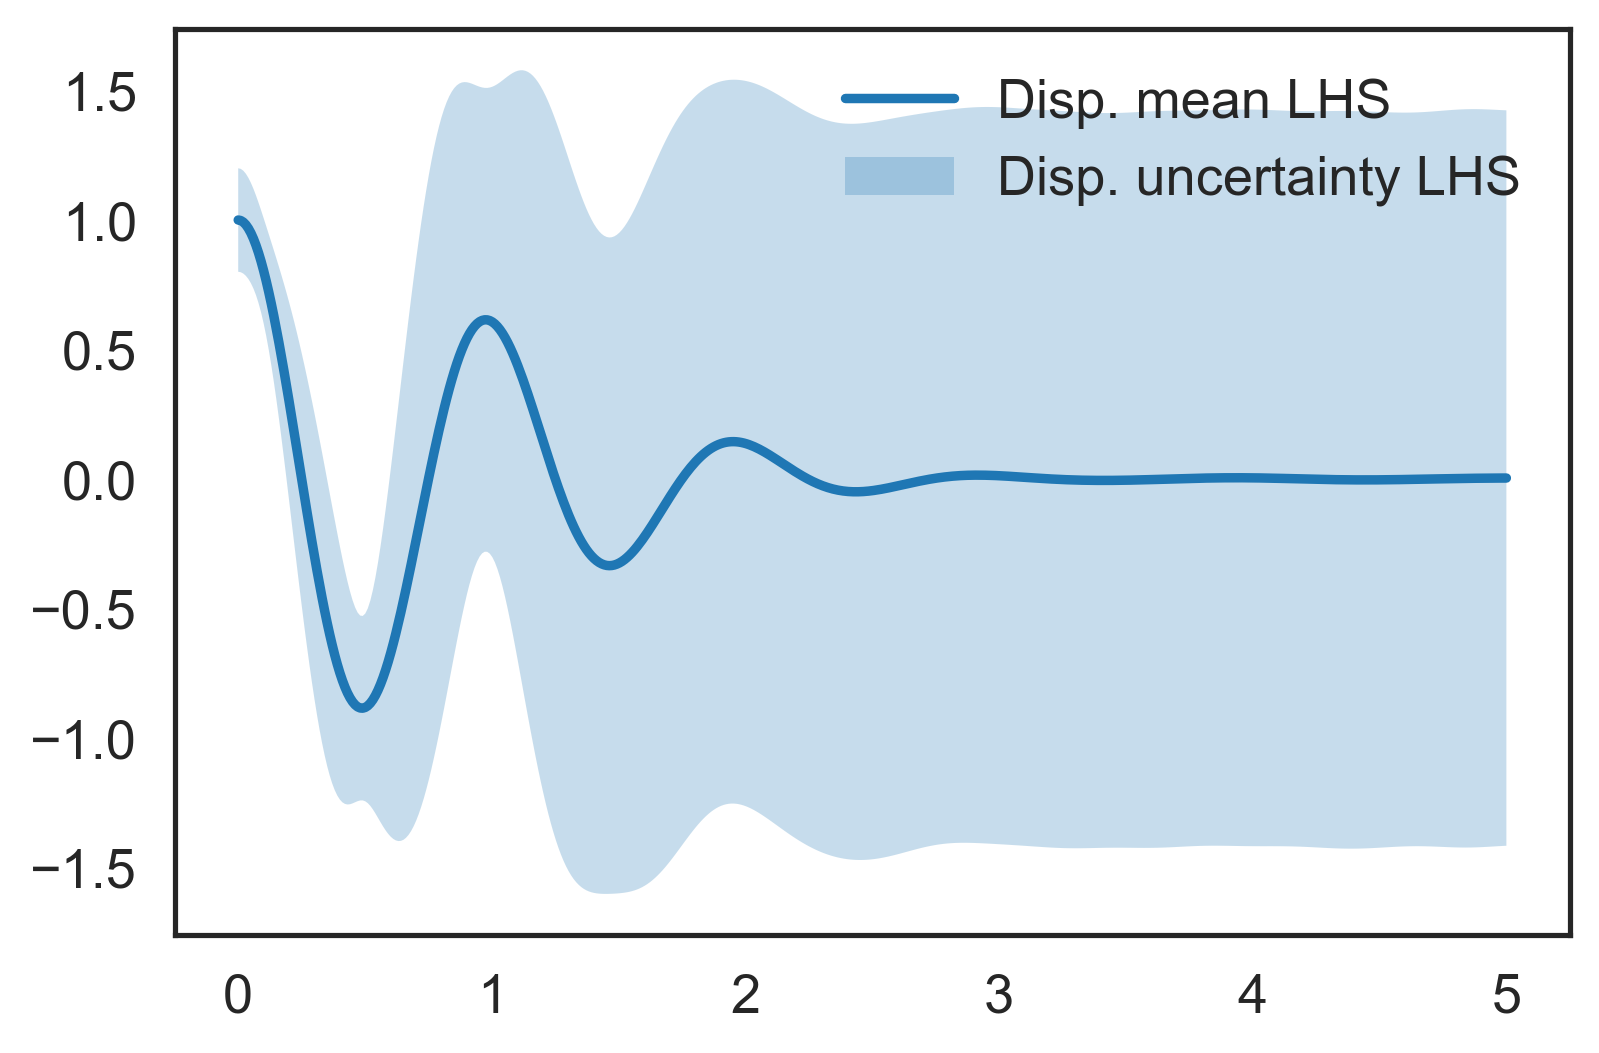

In [11]:
y_mu_lhs = Y_samples.mean(axis=0)
y_std_lhs = Y_samples.std(axis=0)
plt.plot(solver.t,y_mu_lhs, label='Disp. mean LHS')
plt.fill_between(solver.t, y_mu_lhs-2*y_std_lhs, y_mu_lhs+2*y_std_lhs, alpha=0.25, label = 'Disp. uncertainty LHS')
plt.legend(loc='best')

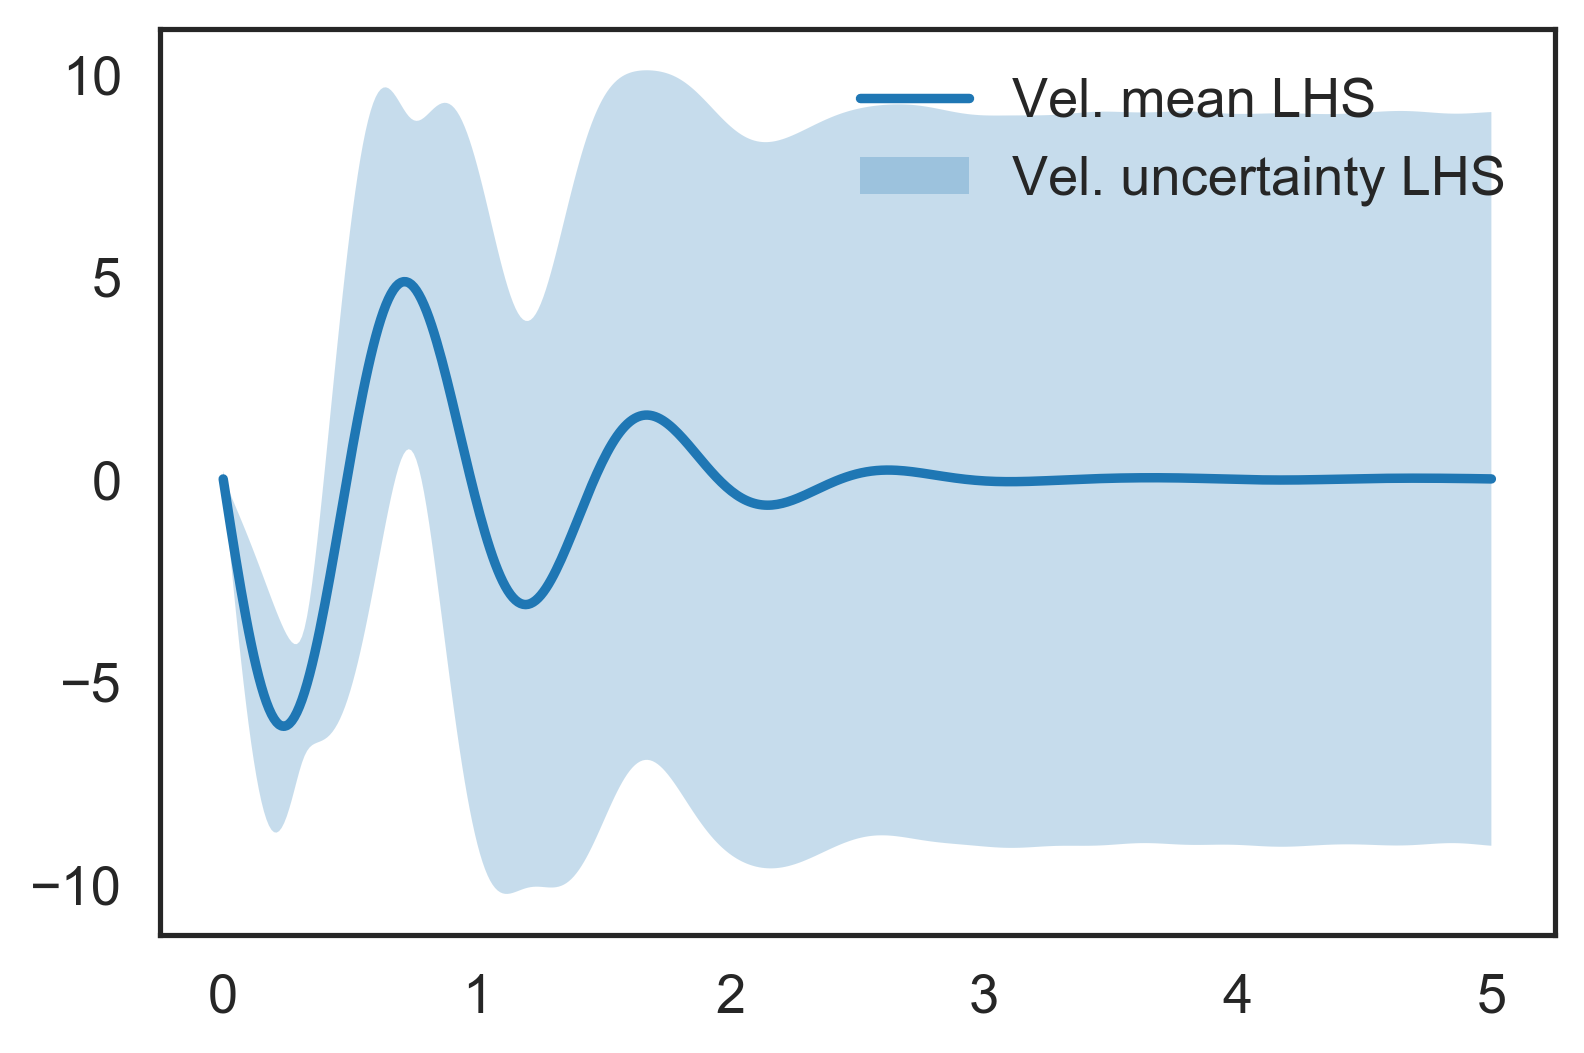

In [12]:
v_mu_lhs = V_samples.mean(axis=0)
v_std_lhs = V_samples.std(axis=0)
plt.plot(solver.t,v_mu_lhs, label='Vel. mean LHS')
plt.fill_between(solver.t, v_mu_lhs-2*v_std_lhs, v_mu_lhs+2*v_std_lhs, alpha=0.25, label = 'Vel. uncertainty LHS')
plt.legend(loc='best')

Now, let $\phi_1(x), \phi_2(x),\dots,\phi_n(x)$ be the orthonormal polynomials of $p(x)$, i.e.
$$
\langle \phi_i, \phi_j \rangle = \int \phi_i(x) \phi_j(x) p(x) dx = \delta_{ij}.
$$
Expand the solution of the dynamical system in these polynomials:
$$
\begin{array}{ccc}
y_1(t;x) &=& \sum_{i=1}^n c_{1i}(t) \phi_i(x),\\
y_2(t;x) &=& \sum_{i=1}^n c_{2i}(t) \phi_i(x).
\end{array}
$$

In [14]:
# Random variable
X1 = st.norm()
X2 = st.norm()
X3 = st.norm()
X = (X1, X2, X3)
dim = len(X)

# Construct the orthonormal polynomials
degree = 2
Phi_set = orthpol.ProductBasis(X, degree=degree)
print Phi_set.num_output

10


We will derive the dynamical system that the $c_{ki}(t)$'s satisfy.

Expand also, $\omega(x), y_0(x)$ and $v_0(x)$:
$$
\begin{array}{ccc}
\omega(x) &=& \sum_{i=1}^n \omega_i \phi_i(x),\\
y_0(x) &=& \sum_{i=1}^n y_{0i} \phi_i(x),\\
v_0(x) &=& \sum_{i=1}^n v_{0i} \phi_i(x).
\end{array}
$$
These coefficients, can all be found with a sparse grid quadrature before we even start:
$$
\begin{array}{ccc}
\omega_i &=& \langle \omega, \phi_i\rangle \approx \sum_{k=1}^{n_q}w_k\omega(x_k)\phi_i(x_k),\\
y_{0i} &=& \langle y_0, \phi_i\rangle \approx \sum_{k=1}^{n_q}w_k y_0(x_k)\phi_i(x_k),\\
v_{0i} &=& \langle v_0, \phi_i\rangle \approx \sum_{k=1}^{n_q}w_k v_0(x_k)\phi_i(x_k).
\end{array}
$$

In [15]:
# Modeling of the natural frequency:
omega = lambda x: 2. * np.pi + x[:, 0]
# Initial position
y0 = lambda x: np.ones((x.shape[0],)) + 0.1 * x[:, 1]
# Initial velocity
v0 = lambda x: np.zeros((x.shape[0],)) + 0.1 * x[:, 2]

In [17]:
# Get a quadrature rule - we will talk about the quadrature rules in Lecture 17.
sg_level = 3
Zq, v = design.sparse_grid(dim, sg_level, 'GH') # Gauss-Hermite which uses w(x) = e^{-x^T x} - need to scale:
#Xq = st.norm.ppf(0.5 * (Zq + 1.))
Xq = Zq * np.sqrt(2.)
#w = v / 2
w = v / np.sqrt(np.pi ** dim)
phi_q = Phi_set(Xq)

In [18]:
# Evaluatae all needed coefficients
omegas = np.einsum('k,k,ki->i', w, omega(Xq), phi_q)
y0s = np.einsum('k,k,ki->i', w, y0(Xq), phi_q)
v0s = np.einsum('k,k,ki->i', w, v0(Xq), phi_q)

Now back to the dynamical system.
We have:
$$
\dot{y}_1 = y_2 \Rightarrow \sum_{i=1}^n \dot{c}_{1i} \phi_i(x) = \sum_{i=1}^n c_{2i}\phi_i(x) \Rightarrow \dot{c}_{1i} = c_{2i},
$$
and
$$
\dot{y}_2 = -\omega^2(x) y_1 \Rightarrow \sum_{i=1}^n\dot{c}_{2i}\phi_i(x) = -\left(\sum_{i=1}^n \omega_i \phi_i(x)\right)^2\sum_{j=1}^nc_{1j}\phi_j(x) = -\sum_{i,j,r=1}^n \omega_i\omega_r c_{1j}\phi_i(x)\phi_r(x)\phi_j(x). 
$$

$$
\sum_{i=1}^{n} \dot{c}_{2i}\phi_i(x) = -\sum_{i,j,r=1}^n \omega_i\omega_r c_{1j}\phi_i(x)\phi_r(x)\phi_j(x).
$$

Taking the inner product with the basis functions:
$$
\langle\sum_{i=1}^{n} \dot{c}_{2i}\phi_i(x),  \phi_k(x) \rangle = \langle -\sum_{i,j,r=1}^n \omega_i\omega_r c_{1j}\phi_i(x)\phi_r(x)\phi_j(x), \phi_k(x) \rangle
$$

$$
\implies \dot{c}_{2k}= -\sum_{i,j,r=1}^n \omega_i\omega_r c_{1j} \langle \phi_k(x), \phi_i(x)\phi_r(x)\phi_j(x)  \rangle  
$$

Define, 
$$
H_{irjk} = \langle \phi_i(x)\phi_r(x)\phi_j(x),  \phi_k(x)  \rangle 
\approx \sum_{q=1}^{n_q} w_q \phi_i(x_q) \phi_r(x_q) \phi_j(x_q) \phi_k(x_q)
$$


We get:
$$
\implies \dot{c}_{2k}= -\sum_{i,j,r=1}^n \omega_i\omega_r c_{1j} H_{irjk}
$$


To wrap it up, the dynamical sytem we need to solve is:
$$
\begin{array}{ccc}
\dot{c}_{1k} &=& c_{2k},\\
\dot{c}_{2k} &=& -\sum_{i,j,r=1}^n \omega_i\omega_r c_{1j} H_{irjk},\\
c_{1k}(0) &=& y_{0k},\\
c_{2k}(0) &=& v_{0k},
\end{array}
$$
for $k=1,\dots,n$.

In [20]:
H = np.einsum('q,qi,qj,qr,qk->irjk', w, phi_q, phi_q, phi_q, phi_q)

In [21]:
# Define the dynamical system
n = Phi_set.num_output  #num basis functions 
def c_rhs(c, t):
    c1 = c[:n]
    c2 = c[n:]
    c1_rhs = c2
    c2_rhs = -np.einsum('i,r,j,irjk ->k', omegas, omegas, c1, H)
    return np.hstack([c1_rhs, c2_rhs])

c0 = np.hstack([y0s, v0s])

In [22]:
# Solve the system
t = np.linspace(0, 5, 100)   #get timesteps 
c = scipy.integrate.odeint(c_rhs, c0, t)   #integrate 

In [23]:
# Post proces the results
# Coefficients for the position
c1 = c[:, :n]
# Coefficients for th velocity
c2 = c[:, n:]
# Mean position
y1_m = c1[:, 0]
# Mean velocity
y2_m = c2[:, 0]
# Variance of position
y1_v = np.sum(c1[:, 1:] ** 2, axis=1)
# Variance of velocity
y2_v = np.sum(c2[:, 1:] ** 2, axis=1)
# Lower and upper prediction intervals
y1_s = np.sqrt(y1_v)
y1_l = y1_m - 2. * y1_s
y1_u = y1_m + 2. * y1_s
y2_s = np.sqrt(y2_v)
y2_l = y2_m - 2. * y2_s
y2_u = y2_m + 2. * y2_s

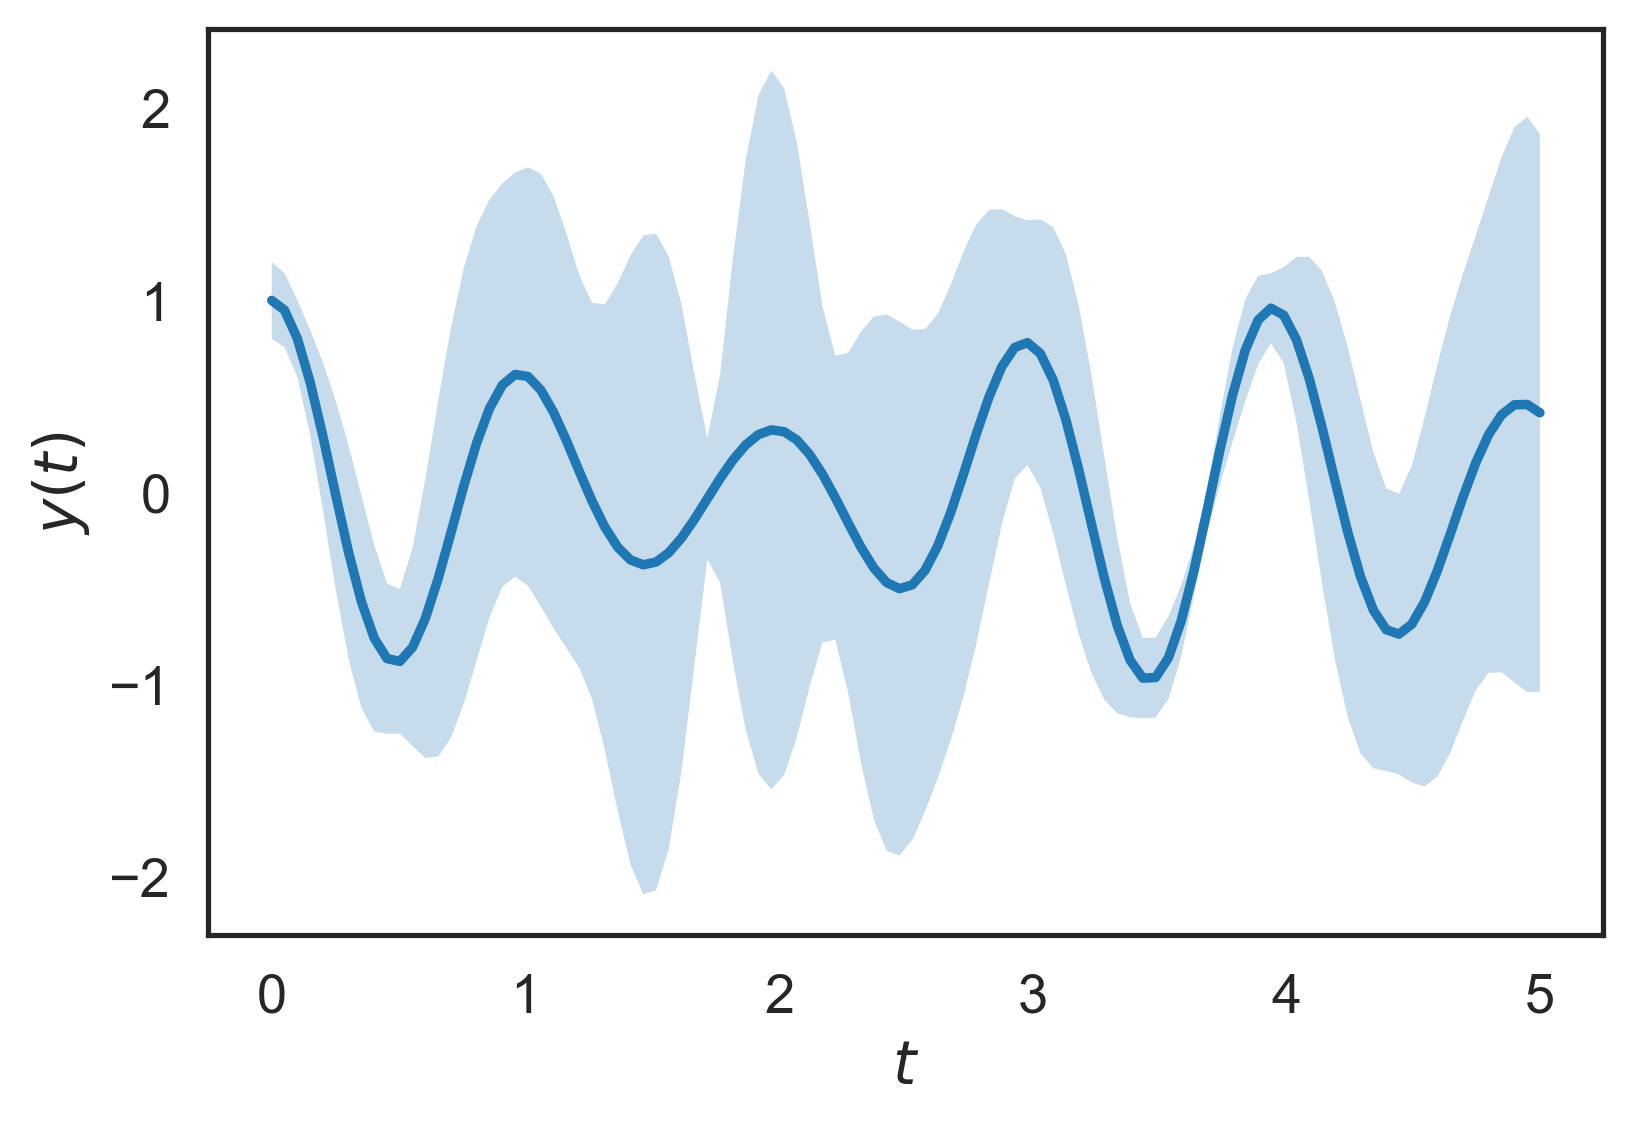

In [24]:
fig, ax = plt.subplots()
ax.plot(t, y1_m)
ax.fill_between(t, y1_l, y1_u, alpha=0.25)
ax.set_xlabel('$t$')
ax.set_ylabel('$y(t)$');

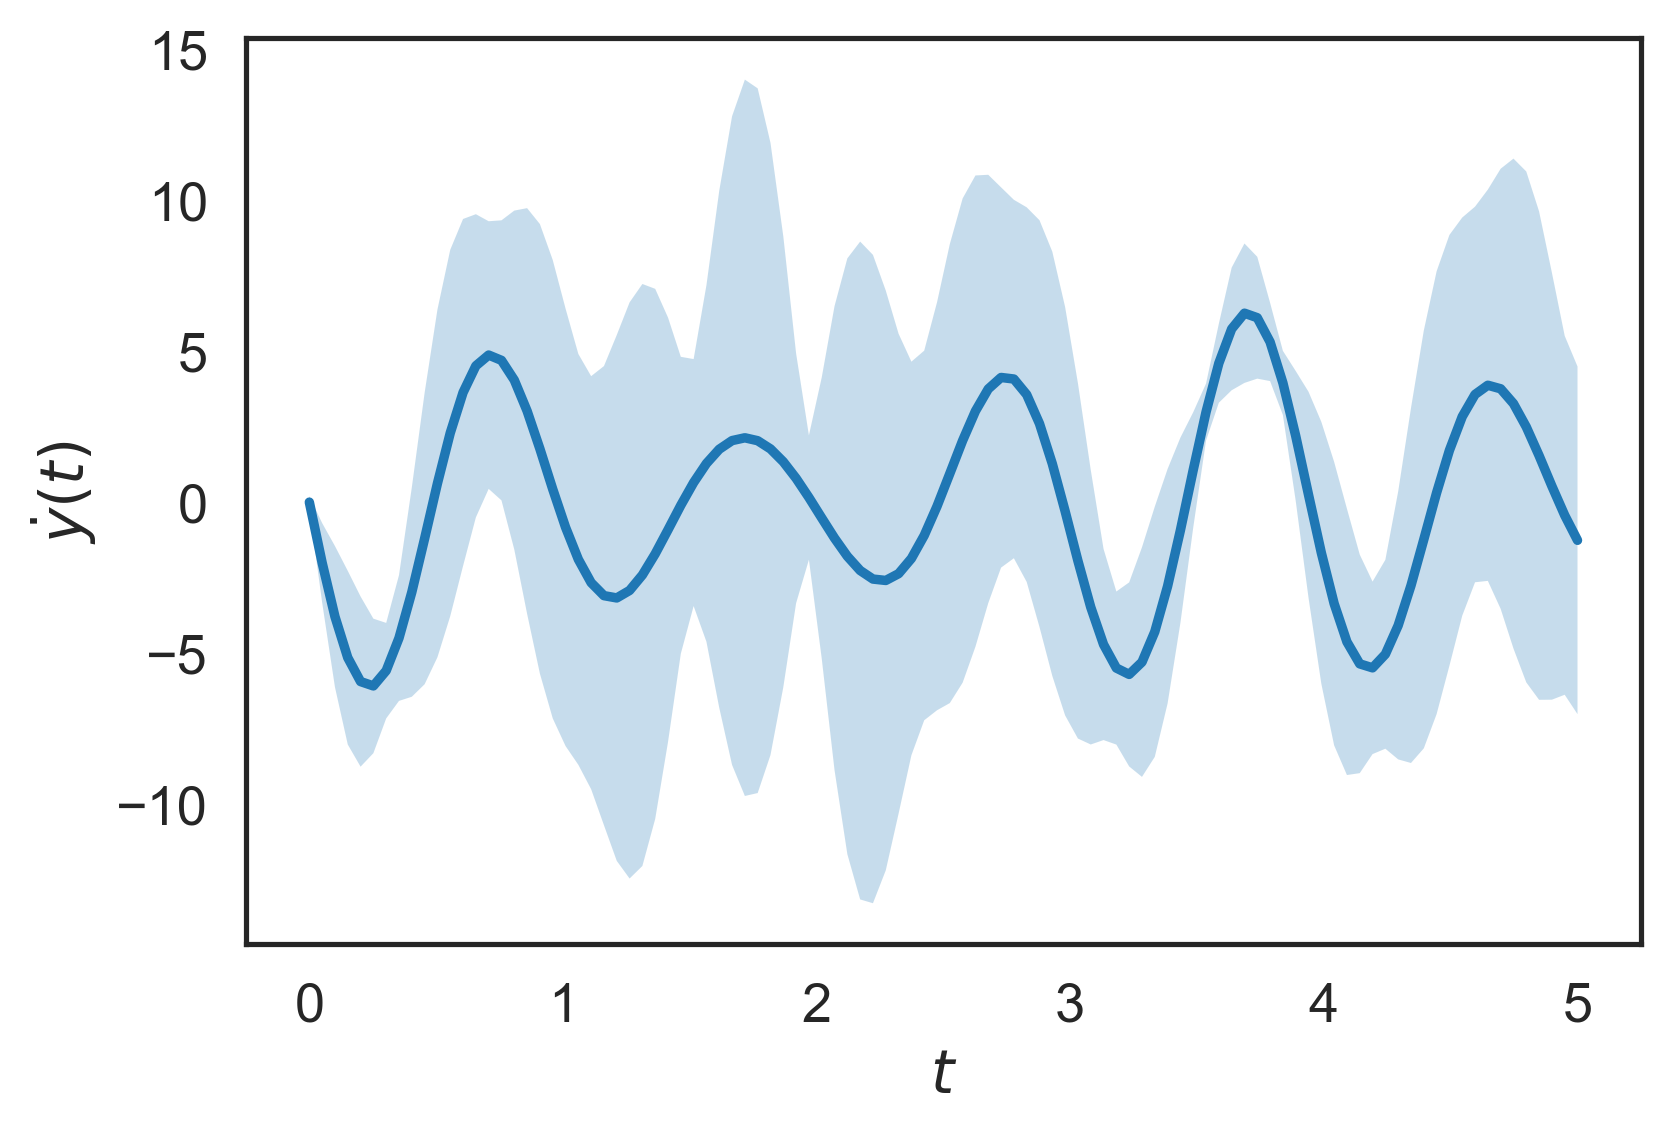

In [25]:
fig, ax = plt.subplots()
ax.plot(t, y2_m)
ax.fill_between(t, y2_l, y2_u, alpha=0.25)
ax.set_xlabel('$t$')
ax.set_ylabel('$\dot{y}(t)$');

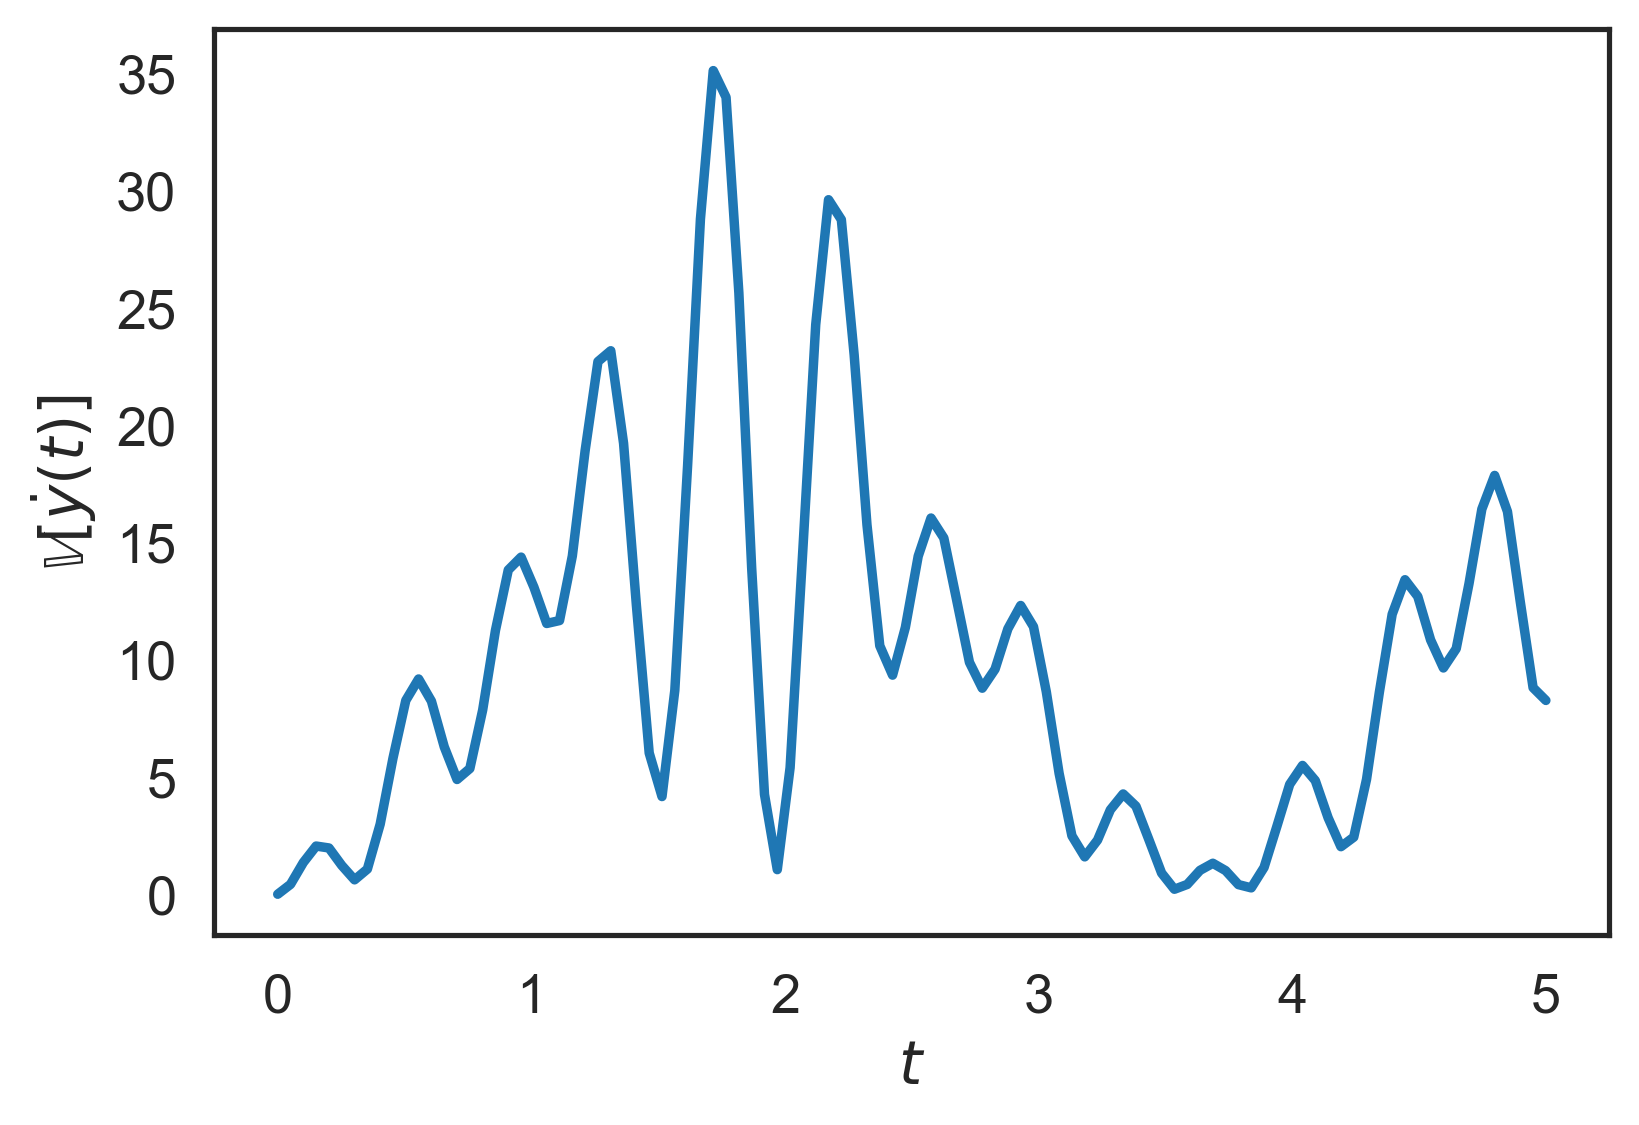

In [26]:
fig, ax = plt.subplots()
ax.plot(t, y2_v)
ax.set_xlabel('$t$')
ax.set_ylabel('$\mathbb{V}[\dot{y}(t)]$');

#### Questions
+ Repeat the analysis with higher polynomial degrees and sparse grid levels focusing on the variance of the velocity as a function of time (last plot). Start a given degree, start increasing the sparse grid level until the results don't change. Then start increasing the polynomial degree. If the results do change as you increase the polynomial degree, start increasing again the sparse grid level. If not, then the solution should have converged. You may want to keep track of your runs by renaming the ``y2_v`` variable.

## Stochastic Collocation Methods: Dynamical Systems

This approach is easily generalizable to other types of problems.
It is basically generalizable to any model you may have as soon as you expand it in a polynomial basis.

As before,lLet $X$ be a random vector with probability density $p(x)$.
Let $\phi_1,\phi_2,\dots$ be an orthonormal basis with respect to $p(x)$.
Consider the stochastic dynamical system:
Consider the $m$-dimensional dynamical system:
$$
\frac{dy}{dt} = g(y;X),
$$
with initial conditions
$$
y(0) = y_0(X).
$$

Assume that the solution $y(t;x)$ is square integrable.
Then, at a given timestep $t$, we take the solution and we expand it in the polynomial basis:
$$
y(t;x) = \sum_{i=1}^\infty c_i(t)\phi_i(x).
$$
Note that the coefficients are functions of time.

### Stochastic Collocation
Let $y(t;x)$ be the solution of the dynamical system at time $t$ for $X=x$.
This can be obtained from a standard numerical solver for dynamical systmes.
Let $w_k$ and $x_k$, $k=1,\dots,q$ be the be a quadrature suitable for computing expectations of the form:
$$
\mathbb{E}[f(X)] \approx \sum_{k=1}^qw_k f(x_k).
$$
Then, we can approximate the coefficients $c_i(t)$ of $y(t;x)$ by:
$$
c_i(t) = \langle y(t;\cdot)\phi_i\rangle = \int y(t;x)\phi_i(x)p(x)dx \approx \sum_{k=1}^qw_ky(t;x_k)\phi_i(x_k).
$$

**Note:** The collocation approach requires only solving the original dynamical system at the quadrature points. 

### Example 3: Dynamical System with Uncertain Parameters
Let us try out the stochastic collocation approach on the first dynamical system with considered.
For convenience, let us repeat the system here.
Take the random vector:
$$
X = (X_1, X_2),
$$
and assume that the components are independent Gaussian:
$$
X_i \sim \mathcal{N}(\mu_i, \sigma_i^2).
$$
So, for the full random vector we have a mean:
$$
\mu = (\mu_1, \mu_2),
$$
and a covariance matrix:
$$
\Sigma = \operatorname{diag}(\sigma_1^2,\sigma_2^2).
$$

Consider the ODE:
  \begin{align*}
    &\dot{y} = \frac{d y(t)}{dt} =-X_1y(t) \equiv g(y,X),\\
    &\qquad y(0) = X_2 \equiv y_0(X).
  \end{align*}
  
All we need really is the solver object, which we already have.

In [ ]:
# SOLUTION WITH STOCHASTIC COLLOCATION

# 1. Construct the random variables - It is not very stable to work with the original 
# random varibales (too little uncertainty).
# So, we work with scaled versions.
mu1 = 0.05; sigma1 = 0.01
sX1 = st.norm()
mu2 = 8; sigma2 = 0.01
sX2 = st.norm()
sX = (sX1, sX2)
dim = len(sX)
mu = np.array([mu1, mu2])
Sigma = np.diag([sigma1 ** 2, sigma2 ** 2])

In [ ]:
# 2. Construct the orthogonal polynomials
degree = 3
Phi_set = orthpol.ProductBasis((sX1, sX2), degree=degree, ncap=1000)

In [ ]:
print Phi_set.num_input
print Phi_set.num_output
print Phi_set.num_terms

In [ ]:
# 3. We need a solver (see previous cells for the definition)
solver = Ex1Solver(nt=500, T=100)

# 4. We need a suitable quadrature rule
sg_level = 1
Z, v = design.sparse_grid(2, sg_level, 'GH') # Gauss-Hermite which uses w(x) = e^{-x^T x} - need to scale:
sXq = Z * np.sqrt(2.)
w = v / np.sqrt(np.pi ** dim)
Xq = np.ndarray(sXq.shape)
Xq[:, 0] = sXq[:, 0] * sigma1 + mu1
Xq[:, 1] = sXq[:, 1] * sigma2 + mu2

# 5. Let's start the stochastic collocation approach
C = np.zeros((solver.nt, Phi_set.num_output)) # Matrix to hold the polynomial coefficients at different times
for i in range(Xq.shape[0]):
    phi_i = Phi_set(sXq[i, :][None, :])
    y_i = solver(Xq[i])[:, 0]
    C += w[i] * y_i[:, None] * phi_i
print 'I did %d solver evaluations!' % Xq.shape[0]

# 6. Extract the statistics
y_pc_col_m = C[:, 0]
y_pc_col_v = np.sum(C[:, 1:] ** 2, axis=1)

In [ ]:
# Make the figure
fig1, ax1 = plt.subplots()

# Plot the mean and compare to LHS
ax1.plot(solver.t, y_mu_lhs, color=sns.color_palette()[0], label='LHS mean ($n=%d$)' % num_lhs)
ax1.plot(t, y_pc_col_m, '--', color=sns.color_palette()[1], label=r'PC COL mean ($\rho=%d$, SG-%d, $n_q=%d$)' % (degree, sg_level, Xq.shape[0]))
ax1.set_xlabel('$t$')
ax1.set_ylabel('$\mu(t)$', color=sns.color_palette()[0])
ax1.tick_params('y', colors=sns.color_palette()[0])
plt.legend(loc='upper right')

# Plot variance and compare to LHS
ax2 = ax1.twinx()
ax2.plot(solver.t, y_var_lhs, color=sns.color_palette()[2], label='LHS variance ($n=%d$)' % (num_lhs))
ax2.plot(solver.t, y_pc_col_v, '--', color=sns.color_palette()[3], label=r'PC COL variance ($\rho=%d$, SG-%d, $n_q=%d$)' % (degree, sg_level, Xq.shape[0]))
ax2.set_ylabel('$\sigma^2(t) = k(t, t)$', color=sns.color_palette()[2])
ax2.tick_params('y', colors=sns.color_palette()[2])
plt.legend(loc='center right');

#### Questions
+ Repeat the analysis with higher sparse grid levels. What level do you need to get convergent results.

+ Start increasing the polynomial degree until the results don't change.

+ Create a stochastic collocation solver for the stochastic oscillator example.